In [16]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt  #visualizer

rankings = pd.read_csv('data/fifa_ranking.csv')  #read in country soccer ranking dataset
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']] #filter out unnecessary data
rankings = rankings.replace({"IR Iran": "Iran", "Korea Republic": "South Korea"}) #process names
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted'] #filter out unnecessary data
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) #convert


matches = pd.read_csv('data/results.csv')
matches =  matches.replace({'Germany DR': 'Germany'}) #process names again
matches['date'] = pd.to_datetime(matches['date'])

#!!!!!!  REMEMBER TO UPDATE.    !!!!!
#wc = ['USA', 'Qatar','Germany','Denmark','Brazil' ,'France' ,'Belgium','Croatia','Spain',
      #'Serbia','England','Switzerland','Argentina','Netherlands','Iran','South Korea',
      #'Japan','Saudi Arabia','Ecuador','Uruguay','Canada','Ghana','Senegal','Portugal','Poland',
      #'Cameroon','Mexico','Wales','Australia','Costa Rica']   #list of qualified teams used as index for later model
wc = pd.read_csv('data/2022data.csv')
wc = wc.loc[:, ['team_index', 'Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
wc = wc.set_index('team_index') #order by the groups
#wc


In [17]:
# rankings by day
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# same country for home and away games: merge them
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
#matches

In [18]:
# create model features
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] >= 0  #assume win if draw and look at other features
matches['is_comp'] = matches['tournament'] != 'Friendly'  #don't want friendly matches 
#matches

/Users/edwardxiong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


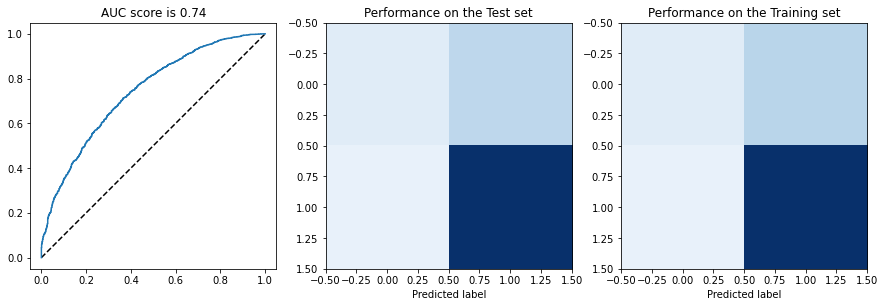

In [19]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_comp']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)  #create the train and test(0.2) splits

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)    #generated model based on train data

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

Stakes distribution in the wrong predictions
True     0.590747
False    0.409253
Name: is_comp, dtype: float64
Stakes distribution overall
True     0.618452
False    0.381548
Name: is_comp, dtype: float64


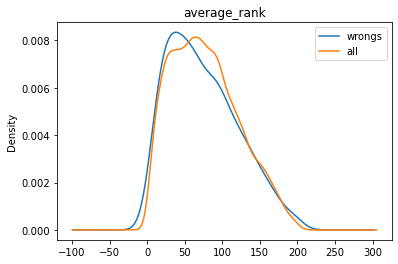

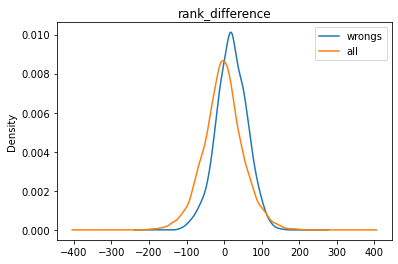

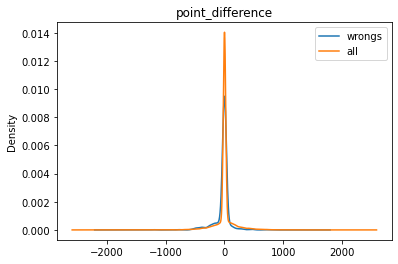

In [20]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_comp'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_comp'].value_counts() / X.shape[0])

In [21]:
#draw margin in case match rankings are too close
margin = 0.01

#most recent WC team rankings
wc_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                rankings['country_full'].isin(wc['Team'])]

wc_rankings = wc_rankings.set_index(['country_full'])
#wc_rankings


In [22]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

wc['points'] = 0
wc['total_prob'] = 0
group_dict = {}
#repeating 4 times: FIX
for group in (wc['Group']):
    print('___Group {}:___'.format(group))
    for home, away in combinations(wc.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = wc_rankings.loc[home, 'rank']
        home_points = wc_rankings.loc[home, 'weighted_points']
        opp_rank = wc_rankings.loc[away, 'rank']
        opp_points = wc_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        wc.loc[home, 'total_prob'] += home_win_prob
        wc.loc[away, 'total_prob'] += 1-home_win_prob

        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            wc.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            wc.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            wc.loc[home, 'points'] += 1
            wc.loc[away, 'points'] += 1

___Group A:___
Qatar vs. Ecuador: Qatar wins with 0.65
Qatar vs. Senegal: Senegal wins with 0.57
Qatar vs. Netherlands: Netherlands wins with 0.64
Ecuador vs. Senegal: Ecuador wins with 0.55
Ecuador vs. Netherlands: Netherlands wins with 0.55
Senegal vs. Netherlands: Senegal wins with 0.52
___Group A:___
Qatar vs. Ecuador: Qatar wins with 0.65
Qatar vs. Senegal: Senegal wins with 0.57
Qatar vs. Netherlands: Netherlands wins with 0.64
Ecuador vs. Senegal: Ecuador wins with 0.55
Ecuador vs. Netherlands: Netherlands wins with 0.55
Senegal vs. Netherlands: Senegal wins with 0.52
___Group A:___
Qatar vs. Ecuador: Qatar wins with 0.65
Qatar vs. Senegal: Senegal wins with 0.57
Qatar vs. Netherlands: Netherlands wins with 0.64
Ecuador vs. Senegal: Ecuador wins with 0.55
Ecuador vs. Netherlands: Netherlands wins with 0.55
Senegal vs. Netherlands: Senegal wins with 0.52
___Group A:___
Qatar vs. Ecuador: Qatar wins with 0.65
Qatar vs. Senegal: Senegal wins with 0.57
Qatar vs. Netherlands: Netherl

In [23]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

wc = wc.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = wc.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Stage: {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = wc_rankings.loc[home, 'rank']
        home_points = wc_rankings.loc[home, 'weighted_points']
        opp_rank = wc_rankings.loc[away, 'rank']
        opp_points = wc_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(wc_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        wc_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")
    wc

___Stage: round_of_16___
Netherlands vs. Iran: Netherlands wins with probability 0.83
Argentina vs. Denmark: Argentina wins with probability 0.55
Germany vs. Croatia: Germany wins with probability 0.87
Brazil vs. Uruguay: Brazil wins with probability 0.65
Senegal vs. England: Senegal wins with probability 0.50
Mexico vs. France: Mexico wins with probability 0.53
Costa Rica vs. Belgium: Belgium wins with probability 0.61
Switzerland vs. Portugal: Portugal wins with probability 0.54


___Stage: quarterfinal___
Netherlands vs. Argentina: Netherlands wins with probability 0.53
Germany vs. Brazil: Germany wins with probability 0.68
Senegal vs. Mexico: Senegal wins with probability 0.53
Belgium vs. Portugal: Belgium wins with probability 0.55


___Stage: semifinal___
Netherlands vs. Germany: Germany wins with probability 0.62
Senegal vs. Belgium: Belgium wins with probability 0.63


___Stage: final___
Germany vs. Belgium: Germany wins with probability 0.62




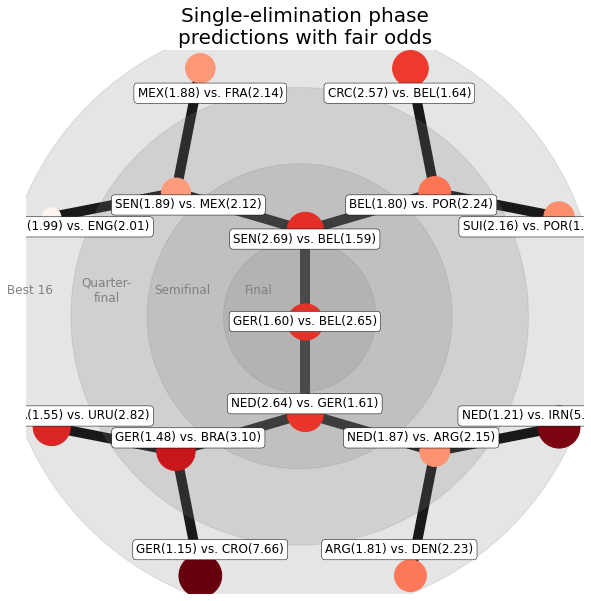

In [26]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()